## This notebook is the solution for Question 1 in he Olive Diagnostic home Assignmnet

### Imports

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from typing import Dict, Any

### Uploading the ata

In [6]:
raw_data = pd.read_csv('data_for_classification.csv')
raw_data.head(10)

,Patient_ID,Protein,pH,Specific_Gravity,Blood,Age,Gender,Glucose,Calcium,Condition
0,1,0.549671,6.463089,1.026997,0,64,Male,81.913568,9.099271,1
1,2,0.486174,6.954708,1.024623,0,51,Female,97.284908,9.665405,1
2,3,0.564769,5.300716,1.020298,0,67,Female,95.883400,9.347795,0
3,4,NaN,6.281485,1.016765,0,41,Female,NaN,9.621079,0
4,5,0.476585,5.674679,1.023491,0,23,Female,96.926143,9.143055,0
5,6,0.476586,5.756437,1.021967,0,24,Male,98.981833,10.345089,0
6,7,0.657921,5.703803,1.024476,0,56,Female,NaN,9.962699,1
7,8,NaN,5.568005,1.023176,0,60,Male,83.292204,9.515891,0
8,9,0.453053,6.024261,1.025248,0,68,Female,111.060597,10.364557,0
9,10,0.554256,5.584525,1.017324,0,32,Male,117.116991,9.537140,0


### Data Handeling

#### Checking for features types

There are outliers in some features - protein, pH, Specific_Gravity, Glucose, and Calcium.

In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Patient_ID        500 non-null    int64  
 1   Protein           450 non-null    float64
 2   pH                450 non-null    float64
 3   Specific_Gravity  450 non-null    float64
 4   Blood             500 non-null    int64  
 5   Age               500 non-null    int64  
 6   Gender            500 non-null    object 
 7   Glucose           450 non-null    float64
 8   Calcium           500 non-null    float64
 9   Condition         500 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 39.2+ KB


There are 9 numeric features, and 1 categorical - 'Gender'. We should map it to numeric values

As can be seen, 'Gender' has to classes- Male and Female
the simplest way to encode to numeric values it is to map it to corresponding numeric values, such as 1 and 0. This maaping actions is simple beacuse this feature has only two classes, and it is not the predicted label (that would be 'Condition')

In [11]:
mapper = {'Male': 1, 'Female': 0}
raw_data['Gender'] = raw_data['Gender'].map(mapper)

raw_data.head(10)

,Patient_ID,Protein,pH,Specific_Gravity,Blood,Age,Gender,Glucose,Calcium,Condition
0,1,0.549671,6.463089,1.026997,0,64,1,81.913568,9.099271,1
1,2,0.486174,6.954708,1.024623,0,51,0,97.284908,9.665405,1
2,3,0.564769,5.300716,1.020298,0,67,0,95.883400,9.347795,0
3,4,NaN,6.281485,1.016765,0,41,0,NaN,9.621079,0
4,5,0.476585,5.674679,1.023491,0,23,0,96.926143,9.143055,0
5,6,0.476586,5.756437,1.021967,0,24,1,98.981833,10.345089,0
6,7,0.657921,5.703803,1.024476,0,56,0,NaN,9.962699,1
7,8,NaN,5.568005,1.023176,0,60,1,83.292204,9.515891,0
8,9,0.453053,6.024261,1.025248,0,68,0,111.060597,10.364557,0
9,10,0.554256,5.584525,1.017324,0,32,1,117.116991,9.537140,0


#### Handeling NaN values

Handleing NaN values approaches are vary between discrad the rows and applying different mathematical techniques such as putting the mean or the meidan value of all the other values, in order to preserve the values scale. First, I think that there is no reason to discard these NaN values, and by looking on the features with NaN values, it can be seen that all of them are continus numeric. Therefore, I think that the right decision is to fill them the median value, because it less sensitive for outliers.

In [9]:
raw_data.isnull().sum()

,0
Patient_ID,0
Protein,50
pH,50
Specific_Gravity,50
Blood,0
Age,0
Gender,0
Glucose,50
Calcium,0
Condition,0


There are some NaN values

Putting the median value

In [31]:
nan_columns = raw_data.columns[raw_data.isna().any()].tolist() # taking only columns with NaN values

for column in nan_columns:
    raw_data[column].fillna(raw_data[column].median(), inplace=True)

print(raw_data.isnull().sum()) # Checking action worked
print()
print(raw_data.info())

Patient_ID          0
Protein             0
pH                  0
Specific_Gravity    0
Blood               0
Age                 0
Gender              0
Glucose             0
Calcium             0
Condition           0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Patient_ID        500 non-null    int64  
 1   Protein           500 non-null    float64
 2   pH                500 non-null    float64
 3   Specific_Gravity  500 non-null    float64
 4   Blood             500 non-null    int64  
 5   Age               500 non-null    int64  
 6   Gender            500 non-null    int64  
 7   Glucose           500 non-null    float64
 8   Calcium           500 non-null    float64
 9   Condition         500 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 39.2 KB
None


#### Checking for outliers

There are few common methods for checking for outliers, the most two common are Z-Scores for nurmal distributed data, and IQR for non-normal distributed. This combined approach allows to leverage the strengths of each method, ensuring that outlier detection is both accurate and appropriate for the naature of the data.

Handeling outliers has two main approaches- discard the outliers, and keep them while performing actions to reduce their effect. Meanwhile, in medical data, outliers can provide a crucial diagnostic information. For example, high glucose might indicate diabetes.
Therfore, I think the second approach is the appropriate approach.

There are some techniques for handleing outliers- transformation (in order to reduce their impact), and imputation (considering them as missing values and treat them as such). I think that the transformation approach is the appropriate one, because of the reason as described above.



In [54]:
def identify_and_transform_outliers(
    data: pd.DataFrame,
    threshold: float = 3,
    label_column: str = 'condition',
    exclude_columns: list = ['age', 'gender', 'id', 'blood'],
    transform: bool = True
) -> Dict[str, Any]:
    """
    Identifies outliers in the DataFrame and applies a transformation to handle them.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing patient urine analysis results and labels.
    - threshold (float): The number of standard deviations from the mean to consider a value as an outlier.
    - label_column (str): The name of the column indicating the presence or absence of the medical condition.
    - exclude_columns (list): List of columns to exclude from outlier detection.
    - transform (bool): Whether to apply a transformation to the outliers.

    Returns:
    - Dict[str, Any]: A dictionary containing outlier information for each numerical column and condition.
    """
    results = {}

    for column in data.select_dtypes(include=[np.number]).columns:
        if column in exclude_columns or column == label_column:
            continue

        groups = data.groupby(label_column)

        for condition, group in groups:
            # Check for normal distribution in the group
            _, p_value = stats.normaltest(group[column].dropna())

            if p_value > 0.05:  # Data is approximately normally distributed
                mean = group[column].mean()
                std = group[column].std()

                # Define bounds for outliers
                lower_bound = mean - threshold * std
                upper_bound = mean + threshold * std

                # Identify outliers
                outlier_mask = (data[label_column] == condition) & (
                    (data[column] < lower_bound) | (data[column] > upper_bound)
                )
            else:  # Data is not normally distributed; use IQR
                q1 = group[column].quantile(0.25)
                q3 = group[column].quantile(0.75)
                iqr = q3 - q1
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr

                # Identify outliers
                outlier_mask = (data[label_column] == condition) & (
                    (data[column] < lower_bound) | (data[column] > upper_bound)
                )

            # Extract outliers
            outliers = data[outlier_mask]

            # Apply transofrmation
            data.loc[outlier_mask & (data[column] < lower_bound), column] = lower_bound
            data.loc[outlier_mask & (data[column] > upper_bound), column] = upper_bound

            # Store outlier information
            results[f'{column}_{condition}'] = {
                'outliers': outliers,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }

    return results

outlier_results = identify_and_transform_outliers(
    data=raw_data,
    threshold=3,
    label_column='Condition',
    exclude_columns=['Age', 'Gender', 'Patient_ID', 'Blood'],  # Exclude specific columns that are not continus
    transform=True
)

# Reporting the Outlier Information
for column_condition, data in outlier_results.items():
    column, condition = column_condition.rsplit('_', 1)
    print(f"\nOutlier Analysis for '{column}' in Condition '{condition}':")
    print(f"Number of Outliers: {len(data['outliers'])}")
    print(f"Lower Bound: {data['lower_bound']}")
    print(f"Upper Bound: {data['upper_bound']}")


Outlier Analysis for 'Protein' in Condition '0':
Number of Outliers: 0
Lower Bound: 0.2231608073451793
Upper Bound: 0.7964549013450622

Outlier Analysis for 'Protein' in Condition '1':
Number of Outliers: 0
Lower Bound: 0.2202678128726201
Upper Bound: 0.752257517111939

Outlier Analysis for 'pH' in Condition '0':
Number of Outliers: 1
Lower Bound: 4.668980371696652
Upper Bound: 7.362857977419205

Outlier Analysis for 'pH' in Condition '1':
Number of Outliers: 0
Lower Bound: 4.515055108694441
Upper Bound: 7.492914067825784

Outlier Analysis for 'Specific_Gravity' in Condition '0':
Number of Outliers: 2
Lower Bound: 1.0066021674940813
Upper Bound: 1.03479789055014

Outlier Analysis for 'Specific_Gravity' in Condition '1':
Number of Outliers: 0
Lower Bound: 1.006191109932671
Upper Bound: 1.034839954959198

Outlier Analysis for 'Glucose' in Condition '0':
Number of Outliers: 0
Lower Bound: 54.730156131802204
Upper Bound: 146.67647162757984

Outlier Analysis for 'Glucose' in Condition '1':

### EDA

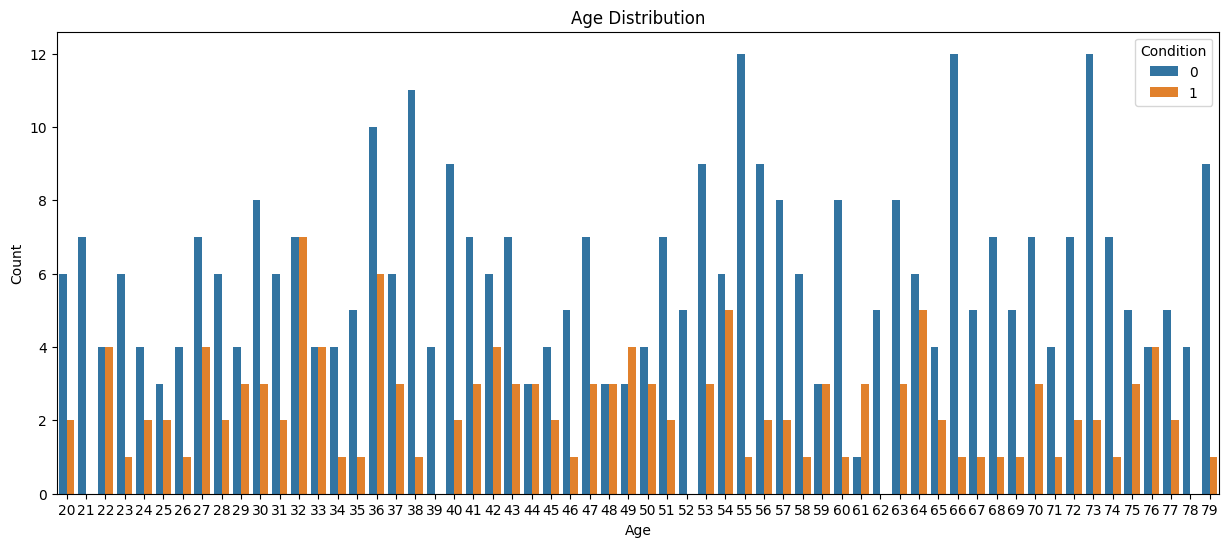

In [67]:
data_ages_groupd = raw_data.groupby('Age')['Condition'].value_counts()

fig = plt.subplots(figsize=(15, 6))
sns.barplot(x=data_ages_groupd.index.get_level_values(0), y=data_ages_groupd.values, hue=data_ages_groupd.index.get_level_values(1))
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()

Ages are between 20 to 79,

<ipython-input-70-06d06821c9ac>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Female', 'Male'])


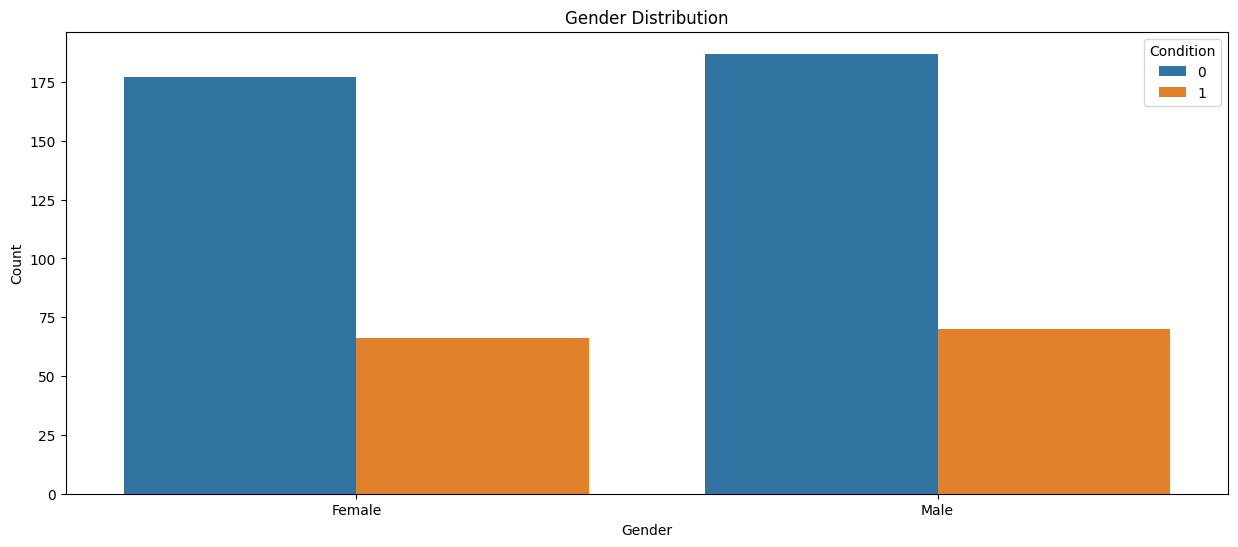

In [70]:
data_gender_groupd = raw_data.groupby('Gender')['Condition'].value_counts()

fig = plt.subplots(figsize=(15, 6))
ax = sns.barplot(x=data_gender_groupd.index.get_level_values(0), y=data_gender_groupd.values, hue=data_gender_groupd.index.get_level_values(1))
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
ax.set_xticklabels(['Female', 'Male'])
plt.show()